In [1]:
#connecting  google drive to colab
from google.colab import drive

In [2]:
#importing libray
import pandas as pd 
import nltk            
from nltk.corpus import stopwords
import string
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers import Embedding
from keras.layers import LSTM, Dense, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
 #file path
 data = pd.read_csv('/content/drive/MyDrive/Translation/eng-ven.csv', encoding='utf-8')
 
data.head()

,source,English,Tshivenḓa
0,ted,Do you have a fever?,Vha na mufhiso?
1,ted,Do you have a cough?,Vha khou hoṱola?
2,ted,Do you have shortness of breath?,Vha khou fhelelwa nga mufemo?
3,ted,Do you have pain?,Vha khou pfa u vhavha?
4,ted,Do you have extreme pain?,Vha khou pfesa u vhavha?


In [5]:
#source of the data
data['source'].value_counts()

ted    283
Name: source, dtype: int64

In [6]:
data = data[data['source']=='ted']

In [7]:
data.head(10)    #first 10 values

,source,English,Tshivenḓa
0,ted,Do you have a fever?,Vha na mufhiso?
1,ted,Do you have a cough?,Vha khou hoṱola?
2,ted,Do you have shortness of breath?,Vha khou fhelelwa nga mufemo?
3,ted,Do you have pain?,Vha khou pfa u vhavha?
4,ted,Do you have extreme pain?,Vha khou pfesa u vhavha?
5,ted,Do you have chest pain?,Vha khou pfa u vhavha kha khana?
6,ted,Do you have a blocked nose?,Vha khou thivhana dziningo?
7,ted,Do you have a runny nose?,Vha khou bvesa maduda?
8,ted,Do you have a sore throat?,Mikulo i khou vhavha?
9,ted,Do you have diarrhea?,Vha khou shuluwa?


In [8]:
data.tail(10)    #last 10 values

,source,English,Tshivenḓa
273,ted,Has your appetite changed?,A vha tshe na lutamo lwa zwiḽiwa?
274,ted,"These are signs of T.B., so we are worried tha...","Hedzi ndi tsumbadwadze dza T.B., zwenezwo ndi ..."
275,ted,We will take some of your sputum to test if yo...,Ri ḓo dzhia tshilambwa uri ri ite ndingo dza T...
276,ted,"We can treat T.B. with medication, which you m...","Ri a kona u alafha T.B. nga mushonga, une vha ..."
277,ted,It is important to take all your medication fo...,Ndi zwa ndeme u shumisa mushonga wavho vha khu...
278,ted,It is important to wear a mask for the first f...,Ndi zwa ndeme u ambara masiki kha vhege dzi si...
279,ted,Are there are children living with you?,Hu na vhana vhane vha khou dzula navho?
280,ted,The children may need to go on treatment as we...,"Vhana vha nga tea u ya kha dzilafho na vhone, ..."
281,ted,The medication for T.B. is generally deemed as...,Mushonga wa T.B. kanzhi u dzhiiwa sa wo tsirel...
282,ted,Would you like me to repeat the question?,Vha a tama ndi tshi dovholola mbudziso?


In [9]:
data.shape

(283, 3)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     283 non-null    object
 1   English    283 non-null    object
 2   Tshivenḓa  283 non-null    object
dtypes: object(3)
memory usage: 8.8+ KB


In [11]:
data.isnull().sum()               #sum of all null values

source       0
English      0
Tshivenḓa    0
dtype: int64

In [12]:
data.columns = ['source','english', 'tshivenda']
data.head()

,source,english,tshivenda
0,ted,Do you have a fever?,Vha na mufhiso?
1,ted,Do you have a cough?,Vha khou hoṱola?
2,ted,Do you have shortness of breath?,Vha khou fhelelwa nga mufemo?
3,ted,Do you have pain?,Vha khou pfa u vhavha?
4,ted,Do you have extreme pain?,Vha khou pfesa u vhavha?


In [13]:
data = data[~pd.isnull(data['english'])]


In [14]:
data.duplicated().sum()   #Words with more than one translation


0

In [15]:
data.drop_duplicates(inplace = True)
data = data.reset_index()
data.drop('index', axis = 1, inplace = True)


In [16]:
def clean(tokens):
  punct = string.punctuation
  h = ''
 
  for z in h:
    if z in tokens:
      tokens = tokens.replace(z,'')        # replacing the ven digits with ''


  if "'" in tokens:
    tokens = tokens.replace("'",'')        # replacing the quotes with ''

  for z in punct:
    if z in tokens:
      tokens = tokens.replace(z,'')        # replacing the punctuation with ''

  for z in tokens.split():
    if z.isnumeric():                      # replacing the digits with ''
      tokens = tokens.replace(z,'')

  tokens = tokens.strip()                  # removing spaces
                
  tokens = tokens.lower()                  # converting the string into lower form
  return tokens

In [17]:
clean1=[]
a = data['english']
b = data['tshivenda']
for i in range(len(a)):
  clean1.append((clean(a[i]),clean(b[i])))          #applying the function to both 'English' and 'Tshivenda'
clean1

[('do you have a fever', 'vha na mufhiso'),
 ('do you have a cough', 'vha khou hoṱola'),
 ('do you have shortness of breath', 'vha khou fhelelwa nga mufemo'),
 ('do you have pain', 'vha khou pfa u vhavha'),
 ('do you have extreme pain', 'vha khou pfesa u vhavha'),
 ('do you have chest pain', 'vha khou pfa u vhavha kha khana'),
 ('do you have a blocked nose', 'vha khou thivhana dziningo'),
 ('do you have a runny nose', 'vha khou bvesa maduda'),
 ('do you have a sore throat', 'mikulo i khou vhavha'),
 ('do you have diarrhea', 'vha khou shuluwa'),
 ('do you have fatigue', 'vha na tshineto'),
 ('do you have vomiting', 'vha khou ṱanza'),
 ('did the fever start about one day ago',
  'mufhiso u na ḓuvha ḽithihi wo thoma'),
 ('did the fever start about two days ago',
  'mufhiso u na maḓuvha mavhili wo thoma'),
 ('did the fever start about three days ago',
  'mufhiso u na maḓuvha mararu wo thoma'),
 ('did the fever start about four days ago',
  'mufhiso u na maḓuvha mana wo thoma'),
 ('did the 

In [18]:
data = pd.DataFrame(clean1)
data.columns = ['english', 'tshivenda']

In [19]:
data['tshivenda'] = data['tshivenda'].apply(lambda x : 'Start_ '+ x + ' _End')   # Adding start and end to sentence


In [20]:
data.head()

,english,tshivenda
0,do you have a fever,Start_ vha na mufhiso _End
1,do you have a cough,Start_ vha khou hoṱola _End
2,do you have shortness of breath,Start_ vha khou fhelelwa nga mufemo _End
3,do you have pain,Start_ vha khou pfa u vhavha _End
4,do you have extreme pain,Start_ vha khou pfesa u vhavha _End


In [21]:
data.tail()

,english,tshivenda
278,it is important to wear a mask for the first f...,Start_ ndi zwa ndeme u ambara masiki kha vhege...
279,are there are children living with you,Start_ hu na vhana vhane vha khou dzula navho ...
280,the children may need to go on treatment as we...,Start_ vhana vha nga tea u ya kha dzilafho na ...
281,the medication for tb is generally deemed as s...,Start_ mushonga wa tb kanzhi u dzhiiwa sa wo t...
282,would you like me to repeat the question,Start_ vha a tama ndi tshi dovholola mbudziso ...


In [22]:
def words(value):
  set1 = set()
  for j in value:
    for i in j.split():
      if i not in set1:
        set1.add(i)
  return set1


In [23]:
def shuffle(l):
    l2 = l[:]           #copy l into l2
    random.shuffle(l2)  #shuffle l2
    return l2  

In [24]:
eng = words(data['english'])
ven = words(data['tshivenda'])

In [25]:
eng_vocab = len(words(data['english']))
eng_vocab

452

In [26]:
ven_vocab = len(words(data['tshivenda']))
ven_vocab

443

In [27]:
count1 = []
for i in range(len(data['tshivenda'])):
  count1.append(len((data['english'][i]).split()))
max_input_length = max(count1)
max_input_length

38

In [28]:
count2 = []
for i in range(len(data['english'])):
  count2.append(len((data['tshivenda'][i]).split()))
max_output_length = max(count2)
max_output_length

43

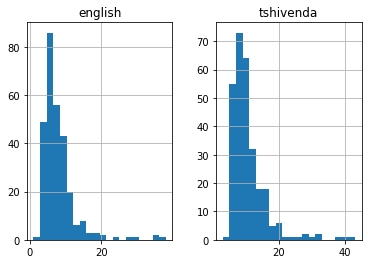

In [29]:
graph = pd.DataFrame({'english':count1, 'tshivenda':count2})
graph.hist(bins = 20)
plt.show()

In [30]:
pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.3.0
aeppl                         0.0.33
aesara                        2.7.9
aiohttp                       3.8.3
aiosignal                     1.3.1
alabaster                     0.7.12
albumentations                1.2.1
altair                        4.2.0
appdirs                       1.4.4
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.1
blis                          0.7.9
bokeh

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split

In [32]:
X, y = np.arange(10).reshape((5, 2)), range(5)

In [33]:
X

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [35]:
X_train

array([[4, 5],
       [0, 1],
       [6, 7]])

In [36]:
y_train

[2, 0, 3]

In [37]:
X_test


array([[2, 3],
       [8, 9]])

In [38]:
y_test

[1, 4]

In [39]:
list(y)

[0, 1, 2, 3, 4]

In [40]:
X, y = data['english'], data['tshivenda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_train.shape, X_test.shape

((240,), (43,))

In [41]:
input_token_index = dict([(word, i+1) for i, word in enumerate(sorted(list(eng)))])                # starting from i+1 i.e. 1 because 0 for padding
target_token_index = dict([(word, i+1) for i, word in enumerate(sorted(list(ven)))])
list(input_token_index.keys())[155],list(input_token_index.values())[155], list(target_token_index.keys())[442], list(target_token_index.values())[442]

('go', 156, 'ṱuluwedza', 443)

In [42]:
rev_input_token_index = dict([(i+1, word) for i, word in enumerate(sorted(list(eng)))])               
rev_target_token_index = dict([(i+1, word) for i, word in enumerate(sorted(list(ven)))])
list(rev_input_token_index.keys())[155],list(rev_input_token_index.values())[155], list(rev_target_token_index.keys())[442], list(rev_target_token_index.values())[442]

(156, 'go', 443, 'ṱuluwedza')

In [43]:
def generate_batch(X = X_train, y = y_train, batch_size = 10):
    
    while True:       # to loop with increment in batches

        for j in range(0, len(X), batch_size):          # here value of j will be len(X)/batch_size

            # Generating numpy arrays
            encoder_input_data = np.zeros((batch_size, max_input_length),dtype='float32')   # 2d array with rows= batchsize, col = max_input_length
            decoder_input_data = np.zeros((batch_size, max_output_length),dtype='float32')  
             
            # 3d array because we have to one-hot encode them. 
            decoder_target_data = np.zeros((batch_size, max_output_length, num_decoder_tokens),dtype='float32')

            # this is loop for seperate inputs and output. Using zip to calculate simultaneously for input and output.
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):

                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # putting the index of the word at the given position in array.

                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:              # we donot have to include END token, so len-1
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq

                    if t>0:        # we donot have to include START token, so t>0
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [44]:
latent_dim = 256
num_encoder_tokens = eng_vocab +1
num_decoder_tokens = ven_vocab +1

In [45]:
encoder_inputs = Input(shape=(None,))
embedding_layer = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, h, c = encoder_lstm(embedding_layer)
encoder_states = [h, c]

In [46]:
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens,latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

In [47]:
decoder_dense = Dense(num_decoder_tokens, activation='softmax', )
decoder_outputs = decoder_dense(decoder_outputs)

In [48]:
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    115968      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    113664      ['input_2[0][0]']                
                                                                                              

In [50]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 10
epochs = 100

In [51]:
history=model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


24/24 [==============================] - 9s 61ms/step - loss: 1.0837 - accuracy: 0.0323 - val_loss: 1.0936 - val_accuracy: 0.0314
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 1.0147 - accuracy: 0.0376 - val_loss: 1.0862 - val_accuracy: 0.0337
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 1.0016 - accuracy: 0.0389 - val_loss: 1.0835 - val_accuracy: 0.0337
Epoch 4/100
24/24 [==============================] - 1s 22ms/step - loss: 0.9925 - accuracy: 0.0414 - val_loss: 1.0806 - val_accuracy: 0.0343
Epoch 5/100
24/24 [==============================] - 1s 21ms/step - loss: 0.9830 - accuracy: 0.0438 - val_loss: 1.0750 - val_accuracy: 0.0378
Epoch 6/100
24/24 [==============================] - 1s 27ms/step - loss: 0.9731 - accuracy: 0.0450 - val_loss: 1.0725 - val_accuracy: 0.0366
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 0.9640 - accuracy: 0.0480 - val_loss: 1.0680 - val_accuracy: 0.0384
Epoch 8/100
24/24 

In [52]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

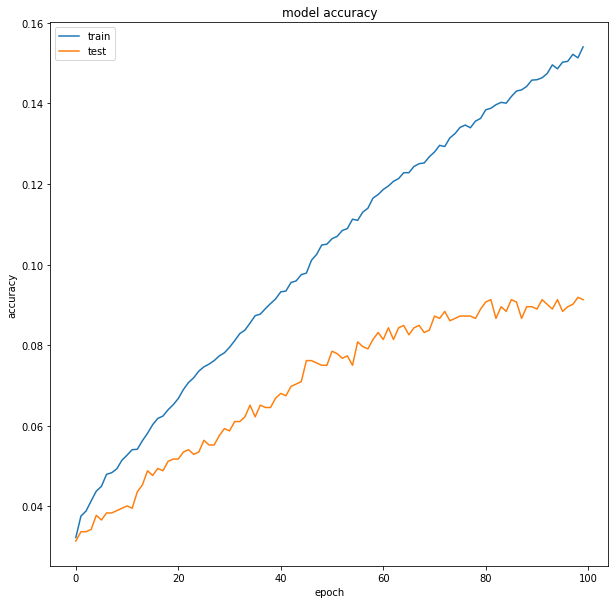

In [54]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

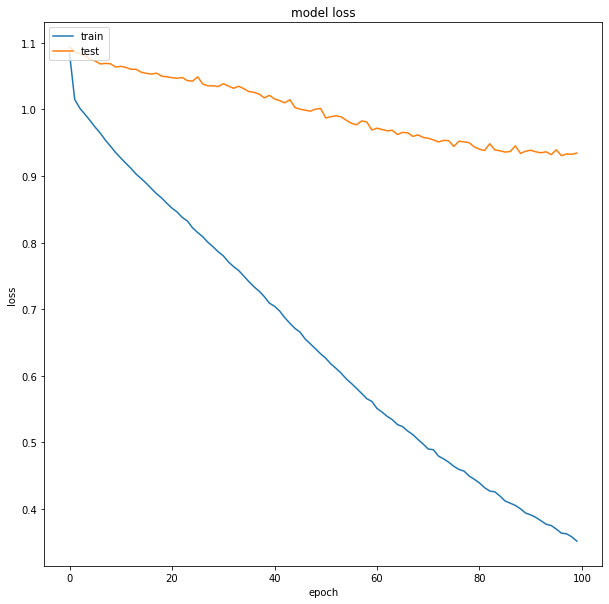

In [55]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
# We call input for both hidden state and cell state 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding = Embedding(num_decoder_tokens,latent_dim)
dec_emb2 = decoder_embedding(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    inputs  = [decoder_inputs] + decoder_states_inputs,
    outputs = [decoder_outputs2] + decoder_states2)

In [57]:
from nltk.translate.bleu_score import sentence_bleu

In [58]:
reference = [
    'A vha tshe na lutamo lwa zwiḽiwa'.split(),
    ' lutamo lwa zwiḽiwa'.split(),
    'zwiḽiwa lwa lutamo'.split(),
    'zwiḽiwa, lwa lutamo'.split() 
]
print(reference)

[['A', 'vha', 'tshe', 'na', 'lutamo', 'lwa', 'zwiḽiwa'], ['lutamo', 'lwa', 'zwiḽiwa'], ['zwiḽiwa', 'lwa', 'lutamo'], ['zwiḽiwa,', 'lwa', 'lutamo']]


In [59]:
candidate = 'lutamo lwa zwiḽiwa'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.2213386697554703e-77


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [60]:
candidate = 'zwiḽiwa lwa lutamo'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))


BLEU score -> 1.2213386697554703e-77


In [61]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'A vha tshe na lutamo lwa zwiḽiwa'.split(),
    ' lutamo lwa zwiḽiwa'.split(),
    'zwiḽiwa lwa lutamo'.split(),
    'zwiḽiwa, lwa lutamo'.split() 
]
candidate = 'lutamo lwa zwiḽiwa'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate )))

candidate = 'lutamo zwiḽiwa'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.2213386697554703e-77
BLEU score -> 1.1049969584438628e-231


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [62]:
from nltk.translate.bleu_score import sentence_bleu
reference = [
    'A vha tshe na lutamo lwa zwiḽiwa'.split(),
    ' lutamo lwa zwiḽiwa?'.split(),
    'zwiḽiwa lwa lutamo'.split(),
    'zwiḽiwa, lwa lutamo'.split() 
]
candidate = 'lutamo lwa zwiḽiwa'.split()

print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 1.000000
Individual 2-gram: 1.000000
Individual 3-gram: 1.000000
Individual 4-gram: 0.000000


In [63]:
score = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
print(score)

1.2213386697554703e-77


In [64]:
encoder_model = Model(encoder_inputs, encoder_states)

In [65]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['Start_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:                  
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)  # we start the llop, the first value being START, its h state will be predicted
                                                                                  # output and input as described above in decoder_model

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])                  # this is to return the max index in the z axis, which represents 
                                                                                  # vocab index axis, to check which index has 1.

        sampled_char = rev_target_token_index[sampled_token_index]             # substituting the digit with corresponding character
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_End' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [66]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [67]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input english sentence:', X_train[k:k+1].values[0])
print('Actual ven Translation:', y_train[k:k+1].values[0][6:-4])


1/1 [==============================] - 0s 17ms/step
Input english sentence: please lift both arms
Actual ven Translation:  vha humbelwa u imisa zwanḓa zwoṱhe 
